In [5]:
import torch
import cv2
import os

import albumentations as A
import pandas as pd

from pathlib import Path
from albumentations.pytorch import ToTensorV2

def is_interactive():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'
#     return True

def mem_usage():
    # CUDA Memory Usage in GB
    return torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

def Normalize(**kwargs):
    kwargs['image'] = (kwargs['image'] / 255.).astype('float32')
    return kwargs

def ToChannels(channels):
    def fn(**kwargs):
        im = kwargs['image']
        
        if channels == 1:
            kwargs['image'] = np.expand_dims(im, -1)
        else:
            kwargs['image'] = np.stack([im]*channels, axis=-1)
        return kwargs
    return fn

class Config(object):
    seed = 42
    root = Path('.')
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    groups_df = pd.read_csv(root / 'gt.csv')
    
    def __init__(
        self,
        epochs=15,
        batch_sizes={'train': 16, 'valid': 32},
        allow_empty=True,
        groups=dict(train=["kidney_1_dense"], valid=["kidney_3_dense"]),
        resolution=224,
        channels=3,
        pretrained=True,
        lr=1e-4,
        patience=2,
        min_lr=0.00001,
        lr_decay=0.75,
    ):
        self.epochs = epochs
        self.batch_sizes = batch_sizes
        
        self.groups = groups
        self.allow_empty = allow_empty
        
        self.input_shape = [resolution, resolution]
        self.channels = channels
        self.pretrained = pretrained
        
        self.lr = lr
        self.patience = patience
        self.min_lr = min_lr
        self.lr_decay = lr_decay
        
        self.transforms = {
            'train': A.Compose([
                A.Resize(*self.input_shape, p=1.0),
                A.RandomBrightnessContrast(p=0.2),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                Normalize,
                ToChannels(self.channels),
                ToTensorV2(),
            ]),

            'valid': A.Compose([
                A.Resize(*self.input_shape, p=1.0),
                Normalize,
                ToChannels(self.channels),
                ToTensorV2(),
            ]),
        }
        
    def __repr__(self):
        return (
            f'\n{self.seed=}'
            f'\n{self.root=}'
            f'\n{self.device=}'
            f'\n{self.lr=}'
            f'\n{self.patience=}'
            f'\n{self.min_lr=}'
            f'\n{self.lr_decay=}'
            f'\n{self.epochs=}'
            f'\n{self.batch_sizes=}'
            f'\n{self.groups=}'
            f'\n{self.channels=}'
            f'\n{self.pretrained=}'
            f'\n{self.input_shape=}'
        )

kwargs = {}
if is_interactive():
    kwargs = dict(epochs=2)
    
config = Config(
    channels=1, pretrained=False,
    resolution=512,
    epochs=70,
    lr=1e-3,
    patience=4,
    lr_decay=0.8,
    batch_sizes={'train': 12, 'valid': 12},
#     batch_sizes={'train': 64, 'valid': 64},
    **kwargs
)

display(config.groups_df.head(10))

config, len(config.groups_df)

,id,rle,group,slice,height,width,img_path,msk_path
0,kidney_1_dense_0000,1 0,kidney_1_dense,0,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
1,kidney_1_dense_0001,1 0,kidney_1_dense,1,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
2,kidney_1_dense_0002,1 0,kidney_1_dense,2,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
3,kidney_1_dense_0003,1 0,kidney_1_dense,3,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
4,kidney_1_dense_0004,1 0,kidney_1_dense,4,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
5,kidney_1_dense_0005,1 0,kidney_1_dense,5,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
6,kidney_1_dense_0006,1 0,kidney_1_dense,6,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
7,kidney_1_dense_0007,1 0,kidney_1_dense,7,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
8,kidney_1_dense_0008,1 0,kidney_1_dense,8,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...
9,kidney_1_dense_0009,1 0,kidney_1_dense,9,1303,912,blood-vessel-segmentation/train/kidney_1_dense...,blood-vessel-segmentation/train/kidney_1_dense...


(
 self.seed=42
 self.root=PosixPath('.')
 self.device=device(type='cpu')
 self.lr=0.001
 self.patience=4
 self.min_lr=1e-05
 self.lr_decay=0.8
 self.epochs=70
 self.batch_sizes={'train': 12, 'valid': 12}
 self.groups={'train': ['kidney_1_dense'], 'valid': ['kidney_3_dense']}
 self.channels=1
 self.pretrained=False
 self.input_shape=[512, 512],
 7429)

In [11]:
import segmentation_models_pytorch as smp

def build_model(config):
    model = smp.Unet(
        encoder_name='timm-mobilenetv3_small_100',
#         encoder_name='resnet34',      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,
        classes=1,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(config.device)
    return model

model = build_model(config)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /Users/broxoli/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth
100%|██████████| 9.78M/9.78M [00:01<00:00, 8.95MB/s]


In [15]:
from matplotlib import pyplot as plt

def make_grid_plot(num_items, cols=3, size=3):
    rows = (num_items + cols - 1)//cols
    cols = min(cols, num_items)
    
    fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    axes = axes.flatten() if cols > 1 else [axes]
    
    fig.tight_layout()
    
    return fig, axes

(<matplotlib.image.AxesImage at 0x2f9eff550>, (463, 703, 3))

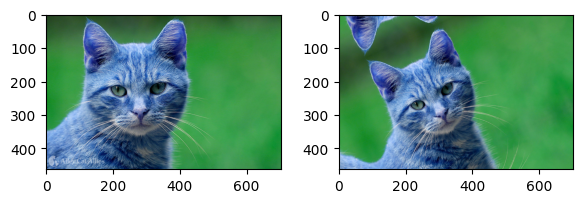

In [337]:
import cv2

import albumentations as A


image = cv2.imread('cat.jpeg', cv2.IMREAD_UNCHANGED)
# input_shape = [512, 512]
input_shape = [256, 256]

_, axes = make_grid_plot(2)

axes[0].imshow(image)

# aug = A.RandomResizedCrop(
#     *input_shape,
#     scale=(.1, .2),
#     # ratio=(1.0, 1.0),
#     interpolation=cv2.INTER_NEAREST,
#     p=1.0,
# )
aug = A.ShiftScaleRotate(
    # shift_limit=0, rotate_limit=0,
    scale_limit=.4,
    interpolation=cv2.INTER_LINEAR,
    p=1.0,
)
# aug = A.RandomScale(scale_limit=.5, p=1.0)
# aug = A.RandomCrop(*input_shape)

aug_image = aug(image=image)['image']

axes[1].imshow(aug_image), aug_image.shape

# Dice Metric

In [6]:
def get_dice(y_pred_classes, y, eps=1e-8):
    y_pred_classes = y_pred_classes.float()
    intersection = (y_pred_classes*y).sum()
    union = (y_pred_classes+y).sum()
    return ((2*intersection + eps)/(union + eps)).cpu().item()

batch_shape = (2, config.channels, *config.input_shape)
y_pred = (torch.randn(*batch_shape) > 0.5).type(torch.float32)
y = (torch.randn(*batch_shape) > 0.5).type(torch.uint8)

get_dice(y_pred, y)

0.3087022304534912

In [12]:
import pickle

metrics = {
    'dice_score': [0.003923559933927091, 0.925687018821114],
    'loss': [0.3151379159406612, 0.002288523606196242],
    'valid_dice_score': [1.4577377339498346e-12, 0.4946871513412112],
    'valid_loss': [0.12292786226386115, 0.00661514383474631]
}

with open('metric.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [13]:
with open('metric.pickle', 'rb') as f:
    metrics = pickle.load(f)
    print(metrics)

{'dice_score': [0.003923559933927091, 0.925687018821114], 'loss': [0.3151379159406612, 0.002288523606196242], 'valid_dice_score': [1.4577377339498346e-12, 0.4946871513412112], 'valid_loss': [0.12292786226386115, 0.00661514383474631]}
